In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import time
from sklearn.svm import LinearSVR
from datetime import timezone
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy==1.19.5

In [ ]:
# from tensorflow.compat.v1.keras.backend import get_session
# tf.compat.v1.disable_v2_behavior()


# Data Prep

In [ ]:
import pandas as pd

data = pd.read_pickle('/content/drive/MyDrive/Thesis/DATASETS/PeMS_dataset.pkl')

In [ ]:
data['Timestamp'] = data['Date'].dt.strftime('%Y-%m-%d').astype('str') +' '+ data['TOD'].astype('str')
data['Timestamp'] = data['Timestamp'].astype(np.datetime64)

In [ ]:
data = data.drop(['Date','TOD'],1).sort_values('Timestamp').reset_index(drop=True)
data.head()

,Travel Time,# Lane Pts,start,end,distance,Timestamp
0,3.38,37,SR 78,Centre City Pkwy,6.28,2020-01-10
1,42.95,441,Orange Co Line/I-605,I-5,77.90,2020-01-10
2,20.00,232,405-N/Wardlow Rd,405-N/National Blvd,35.89,2020-01-10
3,16.48,143,405-N/Sepulveda Blvd,405-N/Onion Ave,30.58,2020-01-10
4,21.83,250,405-N/Wardlow Rd,405-N/State Hwy 2,39.12,2020-01-10


In [ ]:
data

,Travel Time,# Lane Pts,start,end,distance,Timestamp
0,3.38,37,SR 78,Centre City Pkwy,6.28,2020-01-10 00:00:00
1,42.95,441,Orange Co Line/I-605,I-5,77.90,2020-01-10 00:00:00
2,20.00,232,405-N/Wardlow Rd,405-N/National Blvd,35.89,2020-01-10 00:00:00
3,16.48,143,405-N/Sepulveda Blvd,405-N/Onion Ave,30.58,2020-01-10 00:00:00
4,21.83,250,405-N/Wardlow Rd,405-N/State Hwy 2,39.12,2020-01-10 00:00:00
...,...,...,...,...,...,...
211387,16.48,144,405-N/Sepulveda Blvd,405-N/Onion Ave,30.58,2020-06-30 23:55:00
211388,19.82,233,405-N/Wardlow Rd,405-N/National Blvd,35.89,2020-06-30 23:55:00
211389,3.37,37,SR 78,Centre City Pkwy,6.28,2020-06-30 23:55:00
211390,42.82,443,Orange Co Line/I-605,I-5,77.90,2020-06-30 23:55:00


In [ ]:
# data['Timestamp'] = [str(date) for date in data['Timestamp']]

In [ ]:
data['Timestamp'][0]

Timestamp('2020-01-10 00:00:00')

In [ ]:
data['dept_hour'] = data['Timestamp'].dt.hour
data['dept_minute'] = data['Timestamp'].dt.minute
data['dept_dayofweek'] = data['Timestamp'].dt.dayofweek
data['dept_monthofyear'] = data['Timestamp'].dt.month

In [ ]:
# from sklearn.model_selection import train_test_split

# X = data.drop(['Travel Time'],1)
# y = data['Travel Time']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = X['dept_monthofyear'], random_state=1)

In [ ]:
# Encoding make column using LabelEncoder
from sklearn.preprocessing import LabelEncoder

encoded_data = pd.get_dummies(data, columns=['start','end'], drop_first=True)

labelencoder = LabelEncoder()

encoded_data['LanePts'] = labelencoder.fit_transform(encoded_data['# Lane Pts'])

processed_data = encoded_data.drop(['# Lane Pts','Timestamp'],1)

In [ ]:
X, y = processed_data.drop(['Travel Time'],1), processed_data['Travel Time']

In [ ]:
# train_x, train_y = train_data.drop(['Travel Time'],1), train_data['Travel Time']

In [ ]:
# test_x, test_y = test_data.drop(['Travel Time'],1), test_data['Travel Time']

In [ ]:
# len(X_train),len(X_test)
len(X)

211392

In [3]:
# Using SciKit Learn

from sklearn.preprocessing import StandardScaler,MinMaxScaler

def data_preprocesing(data,target,data_len):

  scaler = StandardScaler()

  data.iloc[:,0:] = scaler.fit_transform(data.iloc[:,0:].to_numpy())

  X = data
  y = target

  data_x = np.array(X, dtype=float)
  # data_x = data_x.reshape((data_len,17,1))

  target = np.array(y, dtype=float)
  # target = target.reshape(169113,1,1)

  return data_x, target

In [4]:
import pickle

with open('/content/drive/MyDrive/Thesis/DATASETS/NU_2_data/train_x.pkl','rb') as f:
  train_x = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/DATASETS/NU_2_data/train_y.pkl','rb') as f:
  train_y = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/DATASETS/NU_2_data/test_x.pkl','rb') as f:
  test_x = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/DATASETS/NU_2_data/test_y.pkl','rb') as f:
  test_y = pickle.load(f)

In [5]:
# data, target = data_preprocesing(X, y, 211392)
train_x, train_y = data_preprocesing(train_x, train_y, 12148)
test_x, test_y = data_preprocesing(test_x, test_y, 3038)

In [ ]:
# train_x, train_y = data[0:167904], target[0:167904]
# test_x, test_y = data[167904:], target[167904:]

In [ ]:
# test_data, test_target = data_preprocesing(test_x, test_y, 43488)

In [ ]:
# test_x = np.array(X, dtype=float)
# data_x = data_x.reshape((data_len,17,1))

In [ ]:
# train_data = processed_data[processed_data.dept_monthofyear < 6]
# test_data = processed_data[processed_data.dept_monthofyear == 6]

# Model Training

In [6]:
# # Tuning of parameters for regression by cross-validation
# K = 2              # Number of cross valiations

# # Parameters for tuning
# parameters = [{'kernel': ['linear'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],'C': [1, 10, 100, 1000, 10000]}]

grid = {'C': np.linspace(0.01, 10),
        'epsilon': np.linspace(0.01, 10)}
    
svr_gridsearch =  LinearSVR(fit_intercept=True, max_iter=20000)

In [7]:
# from sklearn.model_selection import StratifiedKFold

# scorer = make_scorer(mean_squared_error, greater_is_better=False)

# svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

# svr_gs.fit(train_x, train_y)

grid_svr = GridSearchCV(svr_gridsearch, grid, scoring='neg_mean_absolute_error', cv=5)

grid_svr.fit(train_x[0:10000], train_y[0:10000])

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                 fit_intercept=True, intercept_scaling=1.0,
                                 loss='epsilon_insensitive', max_iter=20000,
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 0.01      ,  0.21387755,  0.4177551 ,  0.62163265,  0.8255102 ,
        1.02938776,  1.23326531,  1.43714286,  1.64102041,  1....
        5.10693878,  5.31081633,  5.51469388,  5.71857143,  5.92244898,
        6.12632653,  6.33020408,  6.53408163,  6.73795918,  6.94183673,
        7.14571429,  7.34959184,  7.55346939,  7.75734694,  7.96122449,
        8.16510204,  8.36897959,  8.57285714,  8.77673469,  8.98061224,
        9.1844898 ,  9.38836735,  9.5922449 ,  9.79612245, 10.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring

In [8]:
from sklearn.svm import SVR

model = LinearSVR(C=1.0, epsilon=0.0)

In [9]:
model.fit(train_x,train_y)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

# Save Model

In [10]:
import pickle

file_name = "/content/drive/MyDrive/Thesis/DATASETS/SVR/LinearSVR_NU_2.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

# Load Saved Model

In [11]:
file_name = "/content/drive/MyDrive/Thesis/DATASETS/SVR/LinearSVR_NU_2.pkl"

# load
svr_model_loaded = pickle.load(open(file_name, "rb"))

In [ ]:
# saved_model = tf.keras.models.load_model('LSTM_2_layer.h5')

# Prediction

In [12]:
prediction = svr_model_loaded.predict(test_x)

In [13]:
prediction

array([63.99326898, 51.12010925, 33.41406723, ..., 65.72617726,
       30.67202214,  8.89842191])

In [15]:
import pandas as pd

pre_ac = pd.DataFrame()

pre_ac['Actual'] = test_y
pre_ac['Prediction'] = prediction
pre_ac['travels'] = [l for l in range(0,len(prediction))]

In [ ]:
# pre_ac

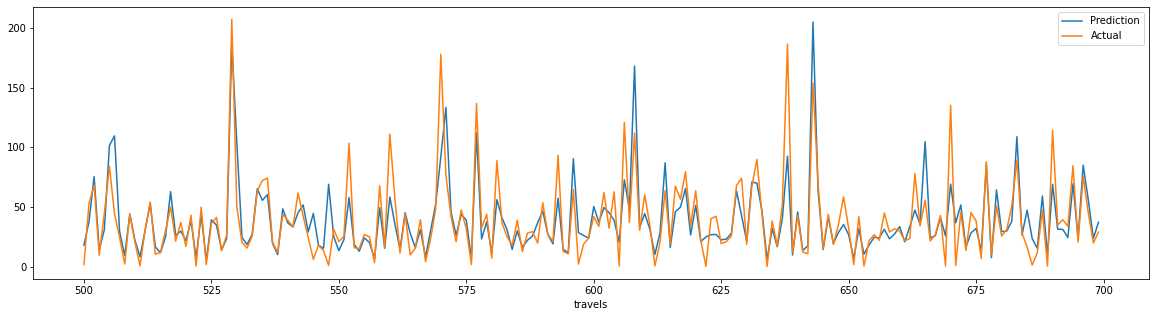

In [17]:
import matplotlib.pyplot as plt

##### plot according to time of day

pre_ac[500:700].plot(x= "travels" , y=['Prediction', 'Actual'])
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [ ]:
# pre_ac.plot()

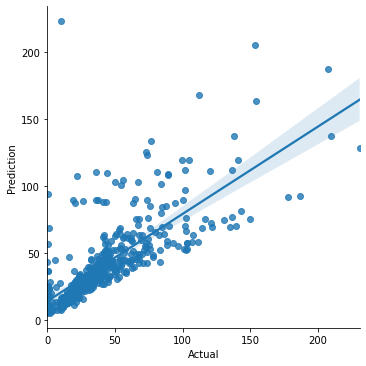

In [18]:
import seaborn as sns

sns.lmplot(x="Actual", y="Prediction", data=pre_ac[500:1000]);

In [19]:
from sklearn.metrics import mean_absolute_error, r2_score
import math

# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     mae = mean_absolute_error(test_labels, predictions)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(np.abs(errors / test_labels))
#     accuracy = 100 - mape
#     MSE = np.square(np.subtract(test_labels,predictions)).mean() 
#     RMSE = math.sqrt(MSE)
#     R2 = r2_score(test_labels,predictions)
#     print('Model Performance')
#     print('MAE: {:0.4f} minutes.'.format(np.mean(errors)))
#     print('RMSE: {:0.2f}.'.format(RMSE))
#     print('R2: {:0.2f}.'.format(R2))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy

In [20]:
mae = mean_absolute_error(test_y, prediction)
errors = abs(prediction - test_y)
mape = 100 * np.mean(np.abs(errors / test_y))
accuracy = 100 - mape
MSE = np.square(np.subtract(test_y,prediction)).mean() 
RMSE = math.sqrt(MSE)
R2 = r2_score(test_y,prediction)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
print('Model Performance')
print('MAE: {:0.4f} minutes.'.format(np.mean(errors)))
print('RMSE: {:0.2f}.'.format(RMSE))
print('R2: {:0.2f}.'.format(R2))
print('MAPE = {:0.2f}%.'.format(mape))
print('Accuracy = {:0.2f}%.'.format(accuracy))

Model Performance
MAE: 14.0058 minutes.
RMSE: 26.20.
R2: 0.52.
MAPE = inf%.
Accuracy = -inf%.


In [ ]:
# SHAP

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 7.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491627 sha256=32abb0f9bf35572339db73b69e215a66db8721ed32cbbaa94f1d9d56c532e2b2
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
import shap

explainer = shap.DeepExplainer(model,data[0:10000])


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


AssertionError: ignored

In [ ]:
shap_values = explainer.shap_values(test_x[0:10])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], test_x[0,:])
